In [28]:
pip install pandas numpy matplotlib seaborn scipy

Note: you may need to restart the kernel to use updated packages.


In [29]:
pip install prettytable

Note: you may need to restart the kernel to use updated packages.


In [30]:
pip install --upgrade seaborn

Note: you may need to restart the kernel to use updated packages.


In [3]:
 ### import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from prettytable import PrettyTable
from tabulate import tabulate
from scipy.stats import ttest_ind
import holoviews as hv
import hvplot.pandas

def load_survey_data(filename):
    try:
        if not filename.endswith('.xlsx'):
            raise ValueError("Unsupported file format. Please use an Excel file.")
        return pd.read_excel(filename, header=0)
    except FileNotFoundError:
        print(f"File not found: {filename}")
        return None
    except ValueError as e:
        print(f"Error: {e}")
        return None
    except Exception as e:
        print(f"Unexpected error: {e}")
        return None

def preprocess_data(data, num_personal_info_cols, choice, categorical_mappings):
    if num_personal_info_cols >= data.shape[1]:
        raise ValueError("Number of personal info columns exceeds total columns.")
        
    if choice == 1:
        data = data.dropna()
    elif choice == 2:
        for column in data.columns[num_personal_info_cols:]:
            if data[column].dtype == 'object':
                data[column].fillna(data[column].mode()[0], inplace=True)
            else:
                data[column].fillna(data[column].mean(), inplace=True)
    elif choice == 3:
        fill_value = input("Enter the value to fill missing data with: ")
        data = data.fillna(fill_value)

    # Convert non-numeric responses if present
    if categorical_mappings:
        for column in data.columns:
            if data[column].dtype == 'object':
                data[column] = data[column].map(categorical_mappings).fillna(data[column])

    return data

def analyze_personal_info(data, num_personal_info_cols):
    profile_analysis = {}
    for column in data.columns[:num_personal_info_cols]:
        counts = data[column].value_counts()
        total = len(data[column])
        percentages = (counts / total * 100).round(0).astype(int)
        profile_analysis[column] = pd.DataFrame({
            'Measure': counts.index,
            'Frequency': counts.values,
            'Percentage': percentages.astype(str) + '%'
        })
    return profile_analysis


def display_profile_table(profile_analysis):
    print("\nProfile of the Respondents:")
    for column, df in profile_analysis.items():
        table = PrettyTable()
        table.field_names = df.columns
        for _, row in df.iterrows():
            table.add_row(row)
        print(f"\n{column} Profile:")
        print(table)
        
def convert_categorical_to_numeric(data, categories):
    converted_data = data.copy()
    for category, mappings in categories.items():
        if category in converted_data.columns:
            converted_data[category] = converted_data[category].map(mappings)
    return converted_data
        
def interpret_verbal(mean, reverse_mapping):
    mean_rounded = round(mean)
    if mean_rounded in reverse_mapping:
        return reverse_mapping[mean_rounded]
    return "No interpretation available"


def analyze_category(data, categories, num_personal_info_cols, reverse_categorical_mappings):
    category_analysis = {}
    overall_analysis = []
    overall_n = []
    for category, questions in categories.items():
        valid_questions = [q for q in questions if q in data.columns[num_personal_info_cols:]]
        if not valid_questions:
            print(f"Warning: No valid questions found for category '{category}'. Skipping this category.")
            continue

        category_data = data[valid_questions]
        n = len(category_data)
        mean = category_data.mean(numeric_only=True)
        std_dev = category_data.std(numeric_only=True)

        # Creating a list for the category analysis
        analysis_data = []

        for question in valid_questions:
            interpretation = interpret_verbal(mean[question], reverse_categorical_mappings)
            analysis_data.append([question, n, f"{mean[question]:.2f}", f"{std_dev[question]:.2f}", interpretation])

        # Calculate category averages
        total_mean = mean.mean()
        total_std_dev = std_dev.mean()
        total_interpretation = interpret_verbal(total_mean, reverse_categorical_mappings)
        analysis_data.append([f"{category} Average", n, f"{total_mean:.2f}", f"{total_std_dev:.2f}", total_interpretation])

        category_analysis[category] = analysis_data

        # Collect data for overall analysis
        overall_n.append(n)
        if analysis_data:
            overall_analysis.append([category, n, f"{total_mean:.2f}", f"{total_std_dev:.2f}", total_interpretation])

    # Add overall row in overall analysis
    if overall_analysis:
        overall_avg_n = np.mean(overall_n)
        overall_means = np.mean([float(row[2]) for row in overall_analysis])
        overall_stdevs = np.mean([float(row[3]) for row in overall_analysis])
        overall_interpretation = interpret_verbal(overall_means, reverse_categorical_mappings)
        overall_analysis.append(["OVERALL", overall_avg_n, f"{overall_means:.2f}", f"{overall_stdevs:.2f}", overall_interpretation])

    return category_analysis, overall_analysis

# Display category analysis using tabulate
def display_category_analysis(category_analysis):
    for category, data in category_analysis.items():
        print(f"\n[CATEGORY: {category}]")
        print(tabulate(data, headers=["Item", "N", "Mean", "Standard Deviation", "Verbal Interpretation"], tablefmt="grid"))

def display_overall_analysis(overall_analysis):
    print("\n[OVERALL CATEGORY ANALYSIS]")
    headers = ["Category", "N", "Mean", "Standard Deviation", "Verbal Interpretation"]
    print(tabulate(overall_analysis, headers=headers, tablefmt="grid"))
    
def analyze_data(data):
    analysis = {
        'mean': data.mean(numeric_only=True),
        'median': data.median(numeric_only=True),
        'std_dev': data.std(numeric_only=True),
        'min': data.min(numeric_only=True),
        'max': data.max(numeric_only=True)
    }
    return analysis

def interpret_results(analysis):
    interpretation = []
    for key, value in analysis.items():
        formatted_value = f"{value:.2f}" if isinstance(value, (int, float)) else value
        interpretation.append(f"{key.title()}: {formatted_value}")
    return '\n'.join(interpretation)

def prompt_for_correlational_analysis():
    response = input("Do you want to analyze the correlation between categories and personal information? (yes/no): ").lower()
    return response == 'yes'

def select_personal_info_for_analysis(data, num_personal_info_cols):
    print("\nList of Personal Information Options:")
    for i, column in enumerate(data.columns[:num_personal_info_cols], start=1):
        print(f"{i}. {column}")
    selected_indices = input("Enter the indices of personal information for analysis (separated by commas): ")
    selected_columns = [data.columns[int(index.strip()) - 1] for index in selected_indices.split(',') if index.strip().isdigit()]
    return selected_columns

def perform_correlational_analysis(data, categories, personal_info_columns):
    correlational_results = {}
    for category, questions in categories.items():
        category_mean = data[questions].mean(axis=1)  # Calculate the mean of each category for each respondent
        results = []
        for personal_info in personal_info_columns:
            group_data = data[[personal_info]].dropna()
            unique_info_values = group_data[personal_info].unique()
            for info_value in unique_info_values:
                group_mean = category_mean[data[personal_info] == info_value]
                t_stat, p_val = ttest_ind(category_mean, group_mean, equal_var=False)
                results.append([personal_info, info_value, len(group_mean), group_mean.mean(), group_mean.std(), t_stat, p_val])
        correlational_results[category] = pd.DataFrame(results, columns=["Personal Info", "Info Value", "N", "Mean", "Std Deviation", "T-Value", "P-Value"]).round({'Mean': 5, 'Std Deviation': 5, 'T-Value': 3, 'P-Value': 3})
    return correlational_results

def display_correlational_results(correlational_results):
    for category, result_df in correlational_results.items():
        print(f"\nCorrelational Analysis for Category: {category}")
        print(tabulate(result_df, headers='keys', tablefmt='grid'))
        for _, row in result_df.iterrows():
            significance_statement = "Significant difference." if row['P-Value'] < 0.05 else "No significant difference."
            print(f"Between {category} and {row['Personal Info']} ({row['Info Value']}): {significance_statement}")
            
def main():
    filename = input("Enter the filename of the survey data: ")
    data = load_survey_data(filename)
    if data is not None:
        num_personal_info_cols = int(input("Enter the number of columns with personal information: "))
        choice = int(input("Choose how to handle missing data (1: Drop, 2: Fill with mean/mode, 3: Fill with a value): "))
        cleaned_data = preprocess_data(data, num_personal_info_cols, choice, {})
        
        # Display profile of respondents
        profile_analysis = analyze_personal_info(cleaned_data, num_personal_info_cols)
        display_profile_table(profile_analysis)
        
        # Assuming reverse_categorical_mappings is defined and needed
        reverse_categorical_mappings = {
            1: 'Low',
            2: 'Medium',
            3: 'High',
            4: 'Very High'
            # Add other mappings as required
        }
        
        # Map non-numeric responses to numeric values
        response = input("Does the survey contain non-numeric responses? (yes/no): ").lower()
        categorical_mappings = {}
        if response == 'yes':
            print("\nProvide a numeric equivalent for each non-numeric response:")
            while True:
                cat_response = input("Enter a non-numeric response (or 'done' to finish): ")
                if cat_response.lower() == 'done':
                    break
                numeric_value = int(input(f"Numeric value for '{cat_response}': "))
                categorical_mappings[cat_response] = numeric_value

        cleaned_data = preprocess_data(data, num_personal_info_cols, choice, categorical_mappings)

        # Display survey questions
        print("\nList of Survey Questions:")
        for i, question in enumerate(cleaned_data.columns[num_personal_info_cols:], start=1):
            print(f"{i}. {question}")

        # Category analysis
        category_input = input("Are there any categories to analyze? (yes/no): ").lower()  # Corrected the variable name here
        categories = {}
        if category_input == 'yes':
            while True:
                category_name = input("Enter the category name (or 'done' to finish): ")
                if category_name.lower() == 'done':
                    break
                question_nums = input(f"Enter numbers for '{category_name}' category questions (separated by commas): ")
                question_indices = [int(num.strip()) - 1 for num in question_nums.split(',') if num.strip().isdigit()]
                questions = [cleaned_data.columns[num_personal_info_cols + i] for i in question_indices]
                categories[category_name] = questions

        if categories:
            category_analysis, overall_analysis = analyze_category(cleaned_data, categories, num_personal_info_cols, reverse_categorical_mappings)
            display_category_analysis(category_analysis)
            display_overall_analysis(overall_analysis)
            
        # Correlational Analysis
        if prompt_for_correlational_analysis():
            personal_info_columns = select_personal_info_for_analysis(cleaned_data, num_personal_info_cols)
            correlational_results = perform_correlational_analysis(cleaned_data, categories, personal_info_columns)
            display_correlational_results(correlational_results)
                    
    else:
        print("No data available for analysis.")

main()

Enter the filename of the survey data: /Users/rolanddelarosa/Pictures/SurveyDataSource.xlsx
Enter the number of columns with personal information: 5
Choose how to handle missing data (1: Drop, 2: Fill with mean/mode, 3: Fill with a value): 2

Profile of the Respondents:

Age Profile:
+---------+-----------+------------+
| Measure | Frequency | Percentage |
+---------+-----------+------------+
|    22   |     34    |    17%     |
|    20   |     33    |    16%     |
|    16   |     31    |    15%     |
|    18   |     29    |    14%     |
|    17   |     27    |    13%     |
|    21   |     26    |    13%     |
|    19   |     23    |    11%     |
+---------+-----------+------------+

Gender Profile:
+---------+-----------+------------+
| Measure | Frequency | Percentage |
+---------+-----------+------------+
|  Female |    136    |    67%     |
|   Male  |     67    |    33%     |
+---------+-----------+------------+

How often do you use TikTok? Profile:
+-----------+-----------+-----

In [8]:
 ### import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from prettytable import PrettyTable
from tabulate import tabulate
from scipy.stats import ttest_ind
import holoviews as hv
import hvplot.pandas

def load_survey_data(filename):
    try:
        if not filename.endswith('.xlsx'):
            raise ValueError("Unsupported file format. Please use an Excel file.")
        return pd.read_excel(filename, header=0)
    except FileNotFoundError:
        print(f"File not found: {filename}")
        return None
    except ValueError as e:
        print(f"Error: {e}")
        return None
    except Exception as e:
        print(f"Unexpected error: {e}")
        return None

def preprocess_data(data, num_personal_info_cols, choice, categorical_mappings):
    if num_personal_info_cols >= data.shape[1]:
        raise ValueError("Number of personal info columns exceeds total columns.")
        
    if choice == 1:
        data = data.dropna()
    elif choice == 2:
        for column in data.columns[num_personal_info_cols:]:
            if data[column].dtype == 'object':
                data[column].fillna(data[column].mode()[0], inplace=True)
            else:
                data[column].fillna(data[column].mean(), inplace=True)
    elif choice == 3:
        fill_value = input("Enter the value to fill missing data with: ")
        data = data.fillna(fill_value)

    # Convert non-numeric responses if present
    if categorical_mappings:
        for column in data.columns:
            if data[column].dtype == 'object':
                data[column] = data[column].map(categorical_mappings).fillna(data[column])

    return data

def analyze_personal_info(data, num_personal_info_cols):
    profile_analysis = {}
    for column in data.columns[:num_personal_info_cols]:
        counts = data[column].value_counts()
        total = len(data[column])
        percentages = (counts / total * 100).round(0).astype(int)
        profile_analysis[column] = pd.DataFrame({
            'Measure': counts.index,
            'Frequency': counts.values,
            'Percentage': percentages.astype(str) + '%'
        })
    return profile_analysis


def display_profile_table(profile_analysis):
    print("\nProfile of the Respondents:")
    for column, df in profile_analysis.items():
        table = PrettyTable()
        table.field_names = df.columns
        for _, row in df.iterrows():
            table.add_row(row)
        print(f"\n{column} Profile:")
        print(table)
        
def convert_categorical_to_numeric(data, categories):
    converted_data = data.copy()
    for category, mappings in categories.items():
        if category in converted_data.columns:
            converted_data[category] = converted_data[category].map(mappings)
    return converted_data
        
def interpret_verbal(mean, reverse_mapping):
    mean_rounded = round(mean)
    return reverse_mapping.get(mean_rounded, "No interpretation available")


def analyze_category(data, categories, num_personal_info_cols, reverse_categorical_mappings):
    category_analysis = {}
    overall_analysis = []
    overall_n = []
    for category, questions in categories.items():
        valid_questions = [q for q in questions if q in data.columns[num_personal_info_cols:]]
        if not valid_questions:
            print(f"Warning: No valid questions found for category '{category}'. Skipping this category.")
            continue

        category_data = data[valid_questions]
        n = len(category_data)
        mean = category_data.mean(numeric_only=True)
        std_dev = category_data.std(numeric_only=True
                                    
        # For each question and overall category
        for question in valid_questions:
            interpretation = interpret_verbal(mean[question], reverse_categorical_mappings)
            analysis_data.append([question, n, f"{mean[question]:.2f}", f"{std_dev[question]:.2f}", interpretation])

        # Creating a list for the category analysis
        analysis_data = []

        for question in valid_questions:
            interpretation = interpret_verbal(mean[question], reverse_categorical_mappings)
            analysis_data.append([question, n, f"{mean[question]:.2f}", f"{std_dev[question]:.2f}", interpretation])

        # Calculate category averages
        total_mean = mean.mean()
        total_std_dev = std_dev.mean()
        total_interpretation = interpret_verbal(total_mean, reverse_categorical_mappings)
        analysis_data.append([f"{category} Average", n, f"{total_mean:.2f}", f"{total_std_dev:.2f}", total_interpretation])

        category_analysis[category] = analysis_data

        # Collect data for overall analysis
        overall_n.append(n)
        if analysis_data:
            overall_analysis.append([category, n, f"{total_mean:.2f}", f"{total_std_dev:.2f}", total_interpretation])

    # Add overall row in overall analysis
    if overall_analysis:
        overall_avg_n = np.mean(overall_n)
        overall_means = np.mean([float(row[2]) for row in overall_analysis])
        overall_stdevs = np.mean([float(row[3]) for row in overall_analysis])
        overall_interpretation = interpret_verbal(overall_means, reverse_categorical_mappings)
        overall_analysis.append(["OVERALL", overall_avg_n, f"{overall_means:.2f}", f"{overall_stdevs:.2f}", overall_interpretation])

    return category_analysis, overall_analysis

# Display category analysis using tabulate
def display_category_analysis(category_analysis):
    for category, data in category_analysis.items():
        print(f"\n[CATEGORY: {category}]")
        print(tabulate(data, headers=["Item", "N", "Mean", "Standard Deviation", "Verbal Interpretation"], tablefmt="grid"))

def display_overall_analysis(overall_analysis):
    print("\n[OVERALL CATEGORY ANALYSIS]")
    headers = ["Category", "N", "Mean", "Standard Deviation", "Verbal Interpretation"]
    print(tabulate(overall_analysis, headers=headers, tablefmt="grid"))
    
def analyze_data(data):
    analysis = {
        'mean': data.mean(numeric_only=True),
        'median': data.median(numeric_only=True),
        'std_dev': data.std(numeric_only=True),
        'min': data.min(numeric_only=True),
        'max': data.max(numeric_only=True)
    }
    return analysis

def interpret_results(analysis):
    interpretation = []
    for key, value in analysis.items():
        formatted_value = f"{value:.2f}" if isinstance(value, (int, float)) else value
        interpretation.append(f"{key.title()}: {formatted_value}")
    return '\n'.join(interpretation)

def prompt_for_correlational_analysis():
    response = input("Do you want to analyze the correlation between categories and personal information? (yes/no): ").lower()
    return response == 'yes'

def select_personal_info_for_analysis(data, num_personal_info_cols):
    print("\nList of Personal Information Options:")
    for i, column in enumerate(data.columns[:num_personal_info_cols], start=1):
        print(f"{i}. {column}")
    selected_indices = input("Enter the indices of personal information for analysis (separated by commas): ")
    selected_columns = [data.columns[int(index.strip()) - 1] for index in selected_indices.split(',') if index.strip().isdigit()]
    return selected_columns

def perform_correlational_analysis(data, categories, personal_info_columns):
    correlational_results = {}
    for personal_info in personal_info_columns:
        results = []
        for category, questions in categories.items():
            category_mean = data[questions].mean(axis=1)  # Calculate the mean of each category for each respondent
            group_data = data[[personal_info]].dropna()
            unique_info_values = group_data[personal_info].unique()
            for info_value in unique_info_values:
                group_mean = category_mean[data[personal_info] == info_value]
                t_stat, p_val = ttest_ind(category_mean, group_mean, equal_var=False)
                results.append([category, info_value, len(group_mean), group_mean.mean(), group_mean.std(), t_stat, p_val])
        correlational_results[personal_info] = pd.DataFrame(results, columns=["Category", "Info Value", "N", "Mean", "Std Deviation", "T-Value", "P-Value"]).round({'Mean': 5, 'Std Deviation': 5, 'T-Value': 3, 'P-Value': 3})
    return correlational_results

def display_correlational_results_with_charts(correlational_results):
    for personal_info, result_df in correlational_results.items():
        print(f"\nCorrelational Analysis for Personal Info: {personal_info}")
        print(tabulate(result_df, headers='keys', tablefmt='grid'))
        for _, row in result_df.iterrows():
            category = row['Category']
            info_value = row['Info Value']
            if row['P-Value'] < 0.05:
                print(f"The analysis shows that {category} has a significant difference with {personal_info} ({info_value}).")
            else:
                print(f"No significant difference found in {category} with {personal_info} ({info_value}).")
            
def main():
    filename = input("Enter the filename of the survey data: ")
    data = load_survey_data(filename)

    if data is not None:
        num_personal_info_cols = int(input("Enter the number of columns with personal information: "))
        choice = int(input("Choose how to handle missing data (1: Drop, 2: Fill with mean/mode, 3: Fill with a value): "))
        cleaned_data = preprocess_data(data, num_personal_info_cols, choice, {})

        # Display profile of respondents
        profile_analysis = analyze_personal_info(cleaned_data, num_personal_info_cols)
        display_profile_table(profile_analysis)

        # Map non-numeric responses to numeric values
        response = input("Does the survey contain non-numeric responses such as satisfaction levels (e.g., 'Very Satisfied', 'Satisfied', 'Neutral', 'Dissatisfied')? (yes/no): ").lower()
        categorical_mappings = {}
        if response == 'yes':
            print("\nExample Table for Non-numeric Response Conversion:")
            print(tabulate([['Very Satisfied', 4], ['Satisfied', 3], ['Neutral', 2], ['Dissatisfied', 1]], headers=['Non-numeric', 'Numeric Equivalent'], tablefmt='grid'))
            print("\nThis is just an example. You should create a mapping based on your own survey responses.")
            print("Provide a numeric equivalent for each non-numeric response:")
            while True:
                cat_response = input("Enter a non-numeric response (or 'done' to finish): ")
                if cat_response.lower() == 'done':
                    break
                numeric_value = int(input(f"Numeric value for '{cat_response}': "))
                categorical_mappings[cat_response] = numeric_value

        cleaned_data = preprocess_data(data, num_personal_info_cols, choice, categorical_mappings)

        # Display survey questions
        print("\nList of Survey Questions:")
        for i, question in enumerate(cleaned_data.columns[num_personal_info_cols:], start=1):
            print(f"{i}. {question}")

        # Category analysis
        print("\nA category in this context refers to a set of survey questions that collectively contribute to a single aspect or main idea. For example, a 'Health' category might include questions about exercise, diet, and medical history.")
        category_input = input("Are there any such categories in your survey to analyze? (yes/no): ").lower()
        categories = {}
        if category_input == 'yes':
            print("Enter the category name, followed by the numbers of the questions that contribute to this category.")
            while True:
                category_name = input("Enter the category name (or 'done' to finish): ")
                if category_name.lower() == 'done':
                    break
                question_nums = input(f"Enter numbers for '{category_name}' category questions (separated by commas): ")
                question_indices = [int(num.strip()) - 1 for num in question_nums.split(',') if num.strip().isdigit()]
                questions = [cleaned_data.columns[num_personal_info_cols + i] for i in question_indices]
                categories[category_name] = questions

        # Define reverse_categorical_mappings here if necessary
        reverse_categorical_mappings = {
            1: 'Low',
            2: 'Medium',
            3: 'High',
            4: 'Very High'
        }
        if categories:
            category_analysis, overall_analysis = analyze_category(cleaned_data, categories, num_personal_info_cols, reverse_categorical_mappings)
            display_category_analysis(category_analysis)
            display_overall_analysis(overall_analysis)

        # Correlational Analysis
        if prompt_for_correlational_analysis():
            personal_info_columns = select_personal_info_for_analysis(cleaned_data, num_personal_info_cols)
            correlational_results = perform_correlational_analysis(cleaned_data, categories, personal_info_columns)
            display_correlational_results(correlational_results)

    else:
        print("No data available for analysis.")

main()

SyntaxError: '(' was never closed (2225775307.py, line 101)

Enter the filename of the survey data: /Users/rolanddelarosa/Pictures/SurveyDataSource.xlsx
Enter the number of columns with personal information: 5
Choose how to handle missing data (1: Drop, 2: Fill with mean/mode, 3: Fill with a value): 2

Profile of the Respondents:

Age Profile:
+---------+-----------+------------+
| Measure | Frequency | Percentage |
+---------+-----------+------------+
|    22   |     34    |    17%     |
|    20   |     33    |    16%     |
|    16   |     31    |    15%     |
|    18   |     29    |    14%     |
|    17   |     27    |    13%     |
|    21   |     26    |    13%     |
|    19   |     23    |    11%     |
+---------+-----------+------------+

Gender Profile:
+---------+-----------+------------+
| Measure | Frequency | Percentage |
+---------+-----------+------------+
|  Female |    136    |    67%     |
|   Male  |     67    |    33%     |
+---------+-----------+------------+

How often do you use TikTok? Profile:
+-----------+-----------+-----

/var/folders/7j/bgyx20753s1cxg66dc1bxgwm0000gn/T/ipykernel_5675/790533413.py:205: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Info Value', y='Mean', data=result_df, hue='Category', ci=None, palette='pastel')


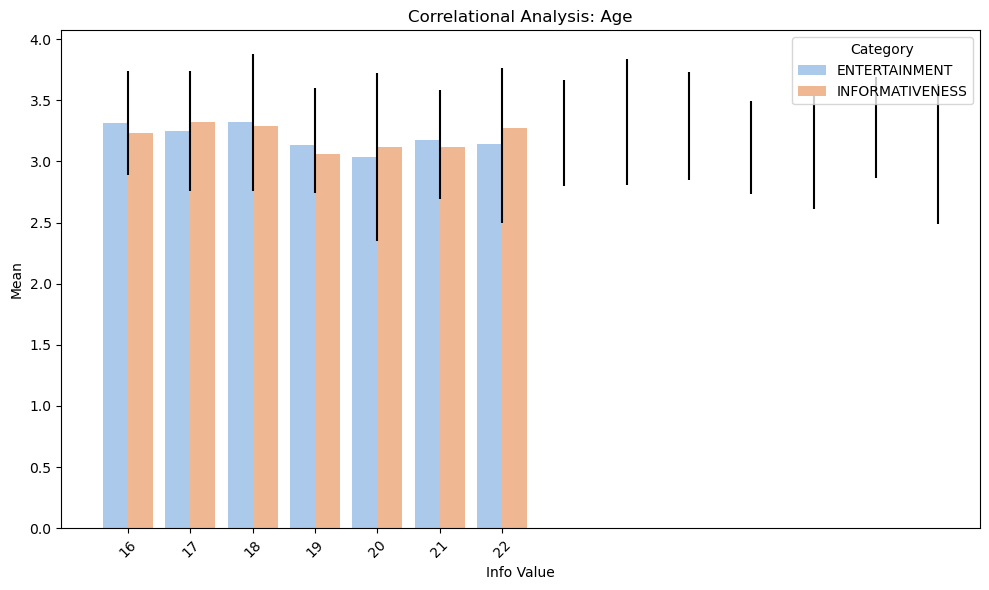


Correlational Analysis for Personal Info: Gender
+----+-----------------+--------------+-----+---------+-----------------+-----------+-----------+
|    | Category        | Info Value   |   N |    Mean |   Std Deviation |   T-Value |   P-Value |
+====+=================+==============+=====+=========+=================+===========+===========+
|  0 | ENTERTAINMENT   | Male         |  67 | 3.07836 |         0.54043 |     1.515 |     0.133 |
+----+-----------------+--------------+-----+---------+-----------------+-----------+-----------+
|  1 | ENTERTAINMENT   | Female       | 136 | 3.25    |         0.52264 |    -0.97  |     0.333 |
+----+-----------------+--------------+-----+---------+-----------------+-----------+-----------+
|  2 | INFORMATIVENESS | Male         |  67 | 3.17313 |         0.42625 |     0.532 |     0.595 |
+----+-----------------+--------------+-----+---------+-----------------+-----------+-----------+
|  3 | INFORMATIVENESS | Female       | 136 | 3.22206 |         0.48

/var/folders/7j/bgyx20753s1cxg66dc1bxgwm0000gn/T/ipykernel_5675/790533413.py:205: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Info Value', y='Mean', data=result_df, hue='Category', ci=None, palette='pastel')


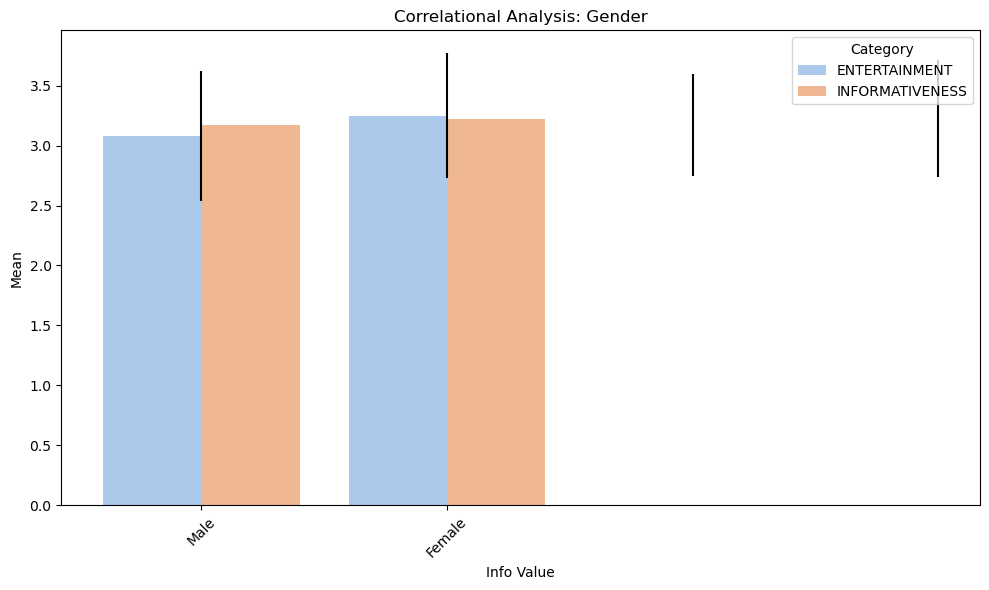


Correlational Analysis for Personal Info: How often do you use TikTok?
+----+-----------------+--------------+-----+---------+-----------------+-----------+-----------+
|    | Category        | Info Value   |   N |    Mean |   Std Deviation |   T-Value |   P-Value |
+====+=================+==============+=====+=========+=================+===========+===========+
|  0 | ENTERTAINMENT   | Always       | 121 | 3.21901 |         0.54061 |    -0.415 |     0.678 |
+----+-----------------+--------------+-----+---------+-----------------+-----------+-----------+
|  1 | ENTERTAINMENT   | Rarely       |   9 | 2.72222 |         0.44096 |     3.106 |     0.012 |
+----+-----------------+--------------+-----+---------+-----------------+-----------+-----------+
|  2 | ENTERTAINMENT   | Often        |  33 | 3.23485 |         0.57602 |    -0.388 |     0.7   |
+----+-----------------+--------------+-----+---------+-----------------+-----------+-----------+
|  3 | ENTERTAINMENT   | Sometimes    |  40 | 

/var/folders/7j/bgyx20753s1cxg66dc1bxgwm0000gn/T/ipykernel_5675/790533413.py:205: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Info Value', y='Mean', data=result_df, hue='Category', ci=None, palette='pastel')


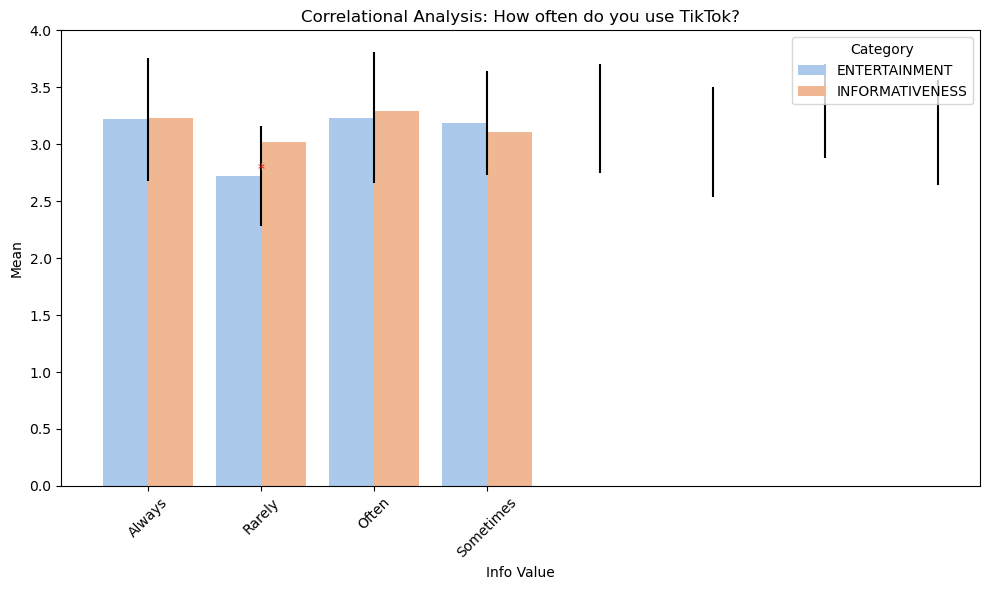


Correlational Analysis for Personal Info: How often do you watch TikTok influencers?
+----+-----------------+--------------+-----+---------+-----------------+-----------+-----------+
|    | Category        | Info Value   |   N |    Mean |   Std Deviation |   T-Value |   P-Value |
+====+=================+==============+=====+=========+=================+===========+===========+
|  0 | ENTERTAINMENT   | Always       |  83 | 3.33133 |         0.54115 |    -1.965 |     0.051 |
+----+-----------------+--------------+-----+---------+-----------------+-----------+-----------+
|  1 | ENTERTAINMENT   | Sometimes    |  59 | 3.07203 |         0.46203 |     1.712 |     0.09  |
+----+-----------------+--------------+-----+---------+-----------------+-----------+-----------+
|  2 | ENTERTAINMENT   | Often        |  51 | 3.19118 |         0.54449 |     0.026 |     0.98  |
+----+-----------------+--------------+-----+---------+-----------------+-----------+-----------+
|  3 | ENTERTAINMENT   | Rarely 

/var/folders/7j/bgyx20753s1cxg66dc1bxgwm0000gn/T/ipykernel_5675/790533413.py:205: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Info Value', y='Mean', data=result_df, hue='Category', ci=None, palette='pastel')


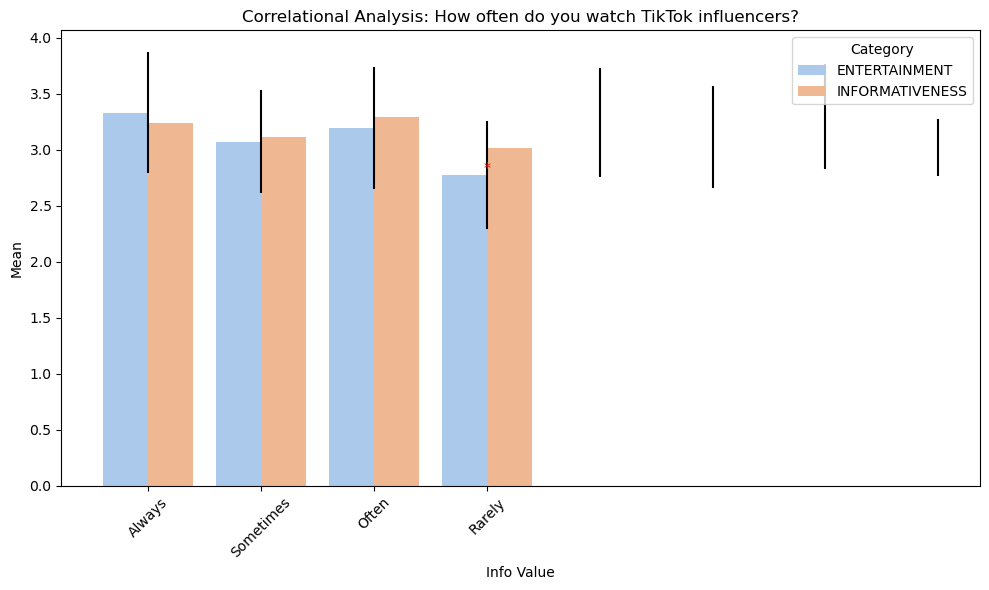

In [7]:
 ### import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from prettytable import PrettyTable
from tabulate import tabulate
from scipy.stats import ttest_ind
import holoviews as hv
import hvplot.pandas

def load_survey_data(filename):
    try:
        if not filename.endswith('.xlsx'):
            raise ValueError("Unsupported file format. Please use an Excel file.")
        return pd.read_excel(filename, header=0)
    except FileNotFoundError:
        print(f"File not found: {filename}")
        return None
    except ValueError as e:
        print(f"Error: {e}")
        return None
    except Exception as e:
        print(f"Unexpected error: {e}")
        return None

def preprocess_data(data, num_personal_info_cols, choice, categorical_mappings):
    if num_personal_info_cols >= data.shape[1]:
        raise ValueError("Number of personal info columns exceeds total columns.")
        
    if choice == 1:
        data = data.dropna()
    elif choice == 2:
        for column in data.columns[num_personal_info_cols:]:
            if data[column].dtype == 'object':
                data[column].fillna(data[column].mode()[0], inplace=True)
            else:
                data[column].fillna(data[column].mean(), inplace=True)
    elif choice == 3:
        fill_value = input("Enter the value to fill missing data with: ")
        data = data.fillna(fill_value)

    # Convert non-numeric responses if present
    if categorical_mappings:
        for column in data.columns:
            if data[column].dtype == 'object':
                data[column] = data[column].map(categorical_mappings).fillna(data[column])

    return data

def analyze_personal_info(data, num_personal_info_cols):
    profile_analysis = {}
    for column in data.columns[:num_personal_info_cols]:
        counts = data[column].value_counts()
        total = len(data[column])
        percentages = (counts / total * 100).round(0).astype(int)
        profile_analysis[column] = pd.DataFrame({
            'Measure': counts.index,
            'Frequency': counts.values,
            'Percentage': percentages.astype(str) + '%'
        })
    return profile_analysis


def display_profile_table(profile_analysis):
    print("\nProfile of the Respondents:")
    for column, df in profile_analysis.items():
        table = PrettyTable()
        table.field_names = df.columns
        for _, row in df.iterrows():
            table.add_row(row)
        print(f"\n{column} Profile:")
        print(table)
        
def convert_categorical_to_numeric(data, categories):
    converted_data = data.copy()
    for category, mappings in categories.items():
        if category in converted_data.columns:
            converted_data[category] = converted_data[category].map(mappings)
    return converted_data
        
def interpret_verbal(mean, reverse_mapping):
    mean_rounded = round(mean)
    if mean_rounded in reverse_mapping:
        return reverse_mapping[mean_rounded]
    return "No interpretation available"


def analyze_category(data, categories, num_personal_info_cols, reverse_categorical_mappings):
    category_analysis = {}
    overall_analysis = []
    overall_n = []
    for category, questions in categories.items():
        valid_questions = [q for q in questions if q in data.columns[num_personal_info_cols:]]
        if not valid_questions:
            print(f"Warning: No valid questions found for category '{category}'. Skipping this category.")
            continue

        category_data = data[valid_questions]
        n = len(category_data)
        mean = category_data.mean(numeric_only=True)
        std_dev = category_data.std(numeric_only=True)

        # Creating a list for the category analysis
        analysis_data = []

        for question in valid_questions:
            interpretation = interpret_verbal(mean[question], reverse_categorical_mappings)
            analysis_data.append([question, n, f"{mean[question]:.2f}", f"{std_dev[question]:.2f}", interpretation])

        # Calculate category averages
        total_mean = mean.mean()
        total_std_dev = std_dev.mean()
        total_interpretation = interpret_verbal(total_mean, reverse_categorical_mappings)
        analysis_data.append([f"{category} OVERALL", n, f"{total_mean:.2f}", f"{total_std_dev:.2f}", total_interpretation])

        category_analysis[category] = analysis_data

        # Collect data for overall analysis
        overall_n.append(n)
        if analysis_data:
            overall_analysis.append([category, n, f"{total_mean:.2f}", f"{total_std_dev:.2f}", total_interpretation])

    # Add overall row in overall analysis
    if overall_analysis:
        overall_avg_n = np.mean(overall_n)
        overall_means = np.mean([float(row[2]) for row in overall_analysis])
        overall_stdevs = np.mean([float(row[3]) for row in overall_analysis])
        overall_interpretation = interpret_verbal(overall_means, reverse_categorical_mappings)
        overall_analysis.append(["OVERALL", overall_avg_n, f"{overall_means:.2f}", f"{overall_stdevs:.2f}", overall_interpretation])

    return category_analysis, overall_analysis

# Display category analysis using tabulate
def display_category_analysis(category_analysis):
    for category, data in category_analysis.items():
        print(f"\n[CATEGORY: {category}]")
        print(tabulate(data, headers=["Item", "N", "Mean", "Standard Deviation", "Verbal Interpretation"], tablefmt="grid"))

def display_overall_analysis(overall_analysis):
    print("\n[OVERALL CATEGORY ANALYSIS]")
    headers = ["Category", "N", "Mean", "Standard Deviation", "Verbal Interpretation"]
    print(tabulate(overall_analysis, headers=headers, tablefmt="grid"))
    
def analyze_data(data):
    analysis = {
        'mean': data.mean(numeric_only=True),
        'median': data.median(numeric_only=True),
        'std_dev': data.std(numeric_only=True),
        'min': data.min(numeric_only=True),
        'max': data.max(numeric_only=True)
    }
    return analysis

def interpret_results(analysis):
    interpretation = []
    for key, value in analysis.items():
        formatted_value = f"{value:.2f}" if isinstance(value, (int, float)) else value
        interpretation.append(f"{key.title()}: {formatted_value}")
    return '\n'.join(interpretation)

def prompt_for_correlational_analysis():
    response = input("Do you want to analyze the correlation between categories and personal information? (yes/no): ").lower()
    return response == 'yes'

def select_personal_info_for_analysis(data, num_personal_info_cols):
    print("\nList of Personal Information Options:")
    for i, column in enumerate(data.columns[:num_personal_info_cols], start=1):
        print(f"{i}. {column}")
    selected_indices = input("Enter the indices of personal information for analysis (separated by commas): ")
    selected_columns = [data.columns[int(index.strip()) - 1] for index in selected_indices.split(',') if index.strip().isdigit()]
    return selected_columns

def perform_correlational_analysis(data, categories, personal_info_columns):
    correlational_results = {}
    for personal_info in personal_info_columns:
        results = []
        for category, questions in categories.items():
            category_mean = data[questions].mean(axis=1)  # Calculate the mean of each category for each respondent
            group_data = data[[personal_info]].dropna()
            unique_info_values = group_data[personal_info].unique()
            for info_value in unique_info_values:
                group_mean = category_mean[data[personal_info] == info_value]
                t_stat, p_val = ttest_ind(category_mean, group_mean, equal_var=False)
                results.append([category, info_value, len(group_mean), group_mean.mean(), group_mean.std(), t_stat, p_val])
        correlational_results[personal_info] = pd.DataFrame(results, columns=["Category", "Info Value", "N", "Mean", "Std Deviation", "T-Value", "P-Value"]).round({'Mean': 5, 'Std Deviation': 5, 'T-Value': 3, 'P-Value': 3})
    return correlational_results

def display_correlational_results(correlational_results):
    for personal_info, result_df in correlational_results.items():
        print(f"\nCorrelational Analysis for Personal Info: {personal_info}")
        print(tabulate(result_df, headers='keys', tablefmt='grid'))
        for _, row in result_df.iterrows():
            significance_statement = "Significant difference." if row['P-Value'] < 0.05 else "No significant difference."
            print(f"Between {row['Category']} and {personal_info} ({row['Info Value']}): {significance_statement}")

def display_correlational_results_with_charts(correlational_results):
    for personal_info, result_df in correlational_results.items():
        print(f"\nCorrelational Analysis for Personal Info: {personal_info}")
        print(tabulate(result_df, headers='keys', tablefmt='grid'))

        # Plotting bar chart with error bars
        plt.figure(figsize=(10, 6))
        sns.barplot(x='Info Value', y='Mean', data=result_df, hue='Category', ci=None, palette='pastel')

        # Adding error bars
        plt.errorbar(x=np.arange(len(result_df)), y=result_df['Mean'], yerr=result_df['Std Deviation'], fmt='none', c='black')

        # Adding annotations for significant differences
        for index, row in result_df.iterrows():
            if row['P-Value'] < 0.05:
                plt.text(index, row['Mean'], '*', ha='center', va='bottom', color='red')

        # Setting title and labels
        plt.title(f'Correlational Analysis: {personal_info}')
        plt.xlabel('Info Value')
        plt.ylabel('Mean')
        plt.legend(title='Category')
        plt.xticks(rotation=45)

        # Show the plot
        plt.tight_layout()
        plt.show()

        
def main():
    filename = input("Enter the filename of the survey data: ")
    data = load_survey_data(filename)

    if data is not None:
        num_personal_info_cols = int(input("Enter the number of columns with personal information: "))
        choice = int(input("Choose how to handle missing data (1: Drop, 2: Fill with mean/mode, 3: Fill with a value): "))
        cleaned_data = preprocess_data(data, num_personal_info_cols, choice, {})

        # Display profile of respondents
        profile_analysis = analyze_personal_info(cleaned_data, num_personal_info_cols)
        display_profile_table(profile_analysis)

        # Map non-numeric responses to numeric values
        response = input("Does the survey contain non-numeric responses such as satisfaction levels (e.g., 'Very Satisfied', 'Satisfied', 'Neutral', 'Dissatisfied')? (yes/no): ").lower()
        categorical_mappings = {}
        if response == 'yes':
            print("\nExample Table for Non-numeric Response Conversion:")
            print(tabulate([['Very Satisfied', 4], ['Satisfied', 3], ['Neutral', 2], ['Dissatisfied', 1]], headers=['Non-numeric', 'Numeric Equivalent'], tablefmt='grid'))
            print("\nThis is just an example. You should create a mapping based on your own survey responses.")
            print("Provide a numeric equivalent for each non-numeric response:")
            while True:
                cat_response = input("Enter a non-numeric response (or 'done' to finish): ")
                if cat_response.lower() == 'done':
                    break
                numeric_value = int(input(f"Numeric value for '{cat_response}': "))
                categorical_mappings[cat_response] = numeric_value

        cleaned_data = preprocess_data(data, num_personal_info_cols, choice, categorical_mappings)

        # Display survey questions
        print("\nList of Survey Questions:")
        for i, question in enumerate(cleaned_data.columns[num_personal_info_cols:], start=1):
            print(f"{i}. {question}")

        # Category analysis
        print("\nA category in this context refers to a set of survey questions that collectively contribute to a single aspect or main idea. For example, a 'Health' category might include questions about exercise, diet, and medical history.")
        category_input = input("Are there any such categories in your survey to analyze? (yes/no): ").lower()
        categories = {}
        if category_input == 'yes':
            print("Enter the category name, followed by the numbers of the questions that contribute to this category.")
            while True:
                category_name = input("Enter the category name (or 'done' to finish): ")
                if category_name.lower() == 'done':
                    break
                question_nums = input(f"Enter numbers for '{category_name}' category questions (separated by commas): ")
                question_indices = [int(num.strip()) - 1 for num in question_nums.split(',') if num.strip().isdigit()]
                questions = [cleaned_data.columns[num_personal_info_cols + i] for i in question_indices]
                categories[category_name] = questions

        # Define reverse_categorical_mappings here if necessary
        reverse_categorical_mappings = {
            # Example: 1: 'Low', 2: 'Medium', 3: 'High', 4: 'Very High'
            # Modify according to your survey's needs
        }

        if categories:
            category_analysis, overall_analysis = analyze_category(cleaned_data, categories, num_personal_info_cols, reverse_categorical_mappings)
            display_category_analysis(category_analysis)
            display_overall_analysis(overall_analysis)

        # Correlational Analysis
        if prompt_for_correlational_analysis():
            personal_info_columns = select_personal_info_for_analysis(cleaned_data, num_personal_info_cols)
            correlational_results = perform_correlational_analysis(cleaned_data, categories, personal_info_columns)
            display_correlational_results_with_charts(correlational_results)

    else:
        print("No data available for analysis.")

main()

In [16]:
 ### import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from prettytable import PrettyTable
from tabulate import tabulate
from scipy.stats import ttest_ind
import holoviews as hv
import hvplot.pandas

def load_survey_data(filename):
    try:
        if not filename.endswith('.xlsx'):
            raise ValueError("Unsupported file format. Please use an Excel file.")
        return pd.read_excel(filename, header=0)
    except FileNotFoundError:
        print(f"File not found: {filename}")
        return None
    except ValueError as e:
        print(f"Error: {e}")
        return None
    except Exception as e:
        print(f"Unexpected error: {e}")
        return None

def preprocess_data(data, num_personal_info_cols, choice, categorical_mappings):
    if num_personal_info_cols >= data.shape[1]:
        raise ValueError("Number of personal info columns exceeds total columns.")
        
    if choice == 1:
        data = data.dropna()
    elif choice == 2:
        for column in data.columns[num_personal_info_cols:]:
            if data[column].dtype == 'object':
                data[column].fillna(data[column].mode()[0], inplace=True)
            else:
                data[column].fillna(data[column].mean(), inplace=True)
    elif choice == 3:
        fill_value = input("Enter the value to fill missing data with: ")
        data = data.fillna(fill_value)

    # Convert non-numeric responses if present
    if categorical_mappings:
        for column in data.columns:
            if data[column].dtype == 'object':
                data[column] = data[column].map(categorical_mappings).fillna(data[column])

    return data

def analyze_personal_info(data, num_personal_info_cols):
    profile_analysis = {}
    for column in data.columns[:num_personal_info_cols]:
        counts = data[column].value_counts()
        total = len(data[column])
        percentages = (counts / total * 100).round(0).astype(int)
        profile_analysis[column] = pd.DataFrame({
            'Measure': counts.index,
            'Frequency': counts.values,
            'Percentage': percentages.astype(str) + '%'
        })
    return profile_analysis


def display_profile_table(profile_analysis):
    print("\nProfile of the Respondents:")
    for column, df in profile_analysis.items():
        table = PrettyTable()
        table.field_names = df.columns
        for _, row in df.iterrows():
            table.add_row(row)
        print(f"\n{column} Profile:")
        print(table)
        
def convert_categorical_to_numeric(data, categories):
    converted_data = data.copy()
    for category, mappings in categories.items():
        if category in converted_data.columns:
            converted_data[category] = converted_data[category].map(mappings)
    return converted_data
        
def interpret_verbal(mean, reverse_mapping):
    mean_rounded = round(mean)
    return reverse_mapping.get(mean_rounded, "No interpretation available")


def analyze_category(data, categories, num_personal_info_cols, reverse_categorical_mappings):
    category_analysis = {}
    overall_analysis = []
    overall_n = []
    for category, questions in categories.items():
        valid_questions = [q for q in questions if q in data.columns[num_personal_info_cols:]]
        if not valid_questions:
            print(f"Warning: No valid questions found for category '{category}'. Skipping this category.")
            continue

        category_data = data[valid_questions]
        n = len(category_data)
        mean = category_data.mean(numeric_only=True)
        std_dev = category_data.std(numeric_only=True)

        # Creating a list for the category analysis
        analysis_data = []
        
        #For each question and overall category
        for question in valid_questions:
            interpretation = interpret_verbal(mean[question], reverse_categorical_mappings)
            analysis_data.append([question, n, f"{mean[question]:.2f}", f"{std_dev[question]:.2f}", interpretation])

        # Calculate category averages
        total_mean = mean.mean()
        total_std_dev = std_dev.mean()
        total_interpretation = interpret_verbal(total_mean, reverse_categorical_mappings)
        analysis_data.append([f"{category} OVERALL", n, f"{total_mean:.2f}", f"{total_std_dev:.2f}", total_interpretation])
        category_analysis[category] = analysis_data

        # Collect data for overall analysis
        overall_n.append(n)
        if analysis_data:
            overall_analysis.append([category, n, f"{total_mean:.2f}", f"{total_std_dev:.2f}", total_interpretation])

    # Add overall row in overall analysis
    if overall_analysis:
        overall_avg_n = np.mean(overall_n)
        overall_means = np.mean([float(row[2]) for row in overall_analysis])
        overall_stdevs = np.mean([float(row[3]) for row in overall_analysis])
        overall_interpretation = interpret_verbal(overall_means, reverse_categorical_mappings)
        overall_analysis.append(["OVERALL", overall_avg_n, f"{overall_means:.2f}", f"{overall_stdevs:.2f}", overall_interpretation])

    return category_analysis, overall_analysis

# Display category analysis using tabulate
def display_category_analysis(category_analysis):
    for category, data in category_analysis.items():
        print(f"\n[CATEGORY: {category}]")
        print(tabulate(data, headers=["Item", "N", "Mean", "Standard Deviation", "Verbal Interpretation"], tablefmt="grid"))

def display_overall_analysis(overall_analysis):
    print("\n[OVERALL CATEGORY ANALYSIS]")
    headers = ["Category", "N", "Mean", "Standard Deviation", "Verbal Interpretation"]
    print(tabulate(overall_analysis, headers=headers, tablefmt="grid"))
    
def analyze_data(data):
    analysis = {
        'mean': data.mean(numeric_only=True),
        'median': data.median(numeric_only=True),
        'std_dev': data.std(numeric_only=True),
        'min': data.min(numeric_only=True),
        'max': data.max(numeric_only=True)
    }
    return analysis

def interpret_results(analysis):
    interpretation = []
    for key, value in analysis.items():
        formatted_value = f"{value:.2f}" if isinstance(value, (int, float)) else value
        interpretation.append(f"{key.title()}: {formatted_value}")
    return '\n'.join(interpretation)

def prompt_for_correlational_analysis():
    response = input("Do you want to analyze the correlation between categories and personal information? (yes/no): ").lower()
    return response == 'yes'

def select_personal_info_for_analysis(data, num_personal_info_cols):
    print("\nList of Personal Information Options:")
    for i, column in enumerate(data.columns[:num_personal_info_cols], start=1):
        print(f"{i}. {column}")
    selected_indices = input("Enter the indices of personal information for analysis (separated by commas): ")
    selected_columns = [data.columns[int(index.strip()) - 1] for index in selected_indices.split(',') if index.strip().isdigit()]
    return selected_columns

def perform_correlational_analysis(data, categories, personal_info_columns):
    correlational_results = {}
    for personal_info in personal_info_columns:
        results = []
        for category, questions in categories.items():
            category_mean = data[questions].mean(axis=1)  # Calculate the mean of each category for each respondent
            group_data = data[[personal_info]].dropna()
            unique_info_values = group_data[personal_info].unique()
            for info_value in unique_info_values:
                group_mean = category_mean[data[personal_info] == info_value]
                t_stat, p_val = ttest_ind(category_mean, group_mean, equal_var=False)
                results.append([category, info_value, len(group_mean), group_mean.mean(), group_mean.std(), t_stat, p_val])
        correlational_results[personal_info] = pd.DataFrame(results, columns=["Category", "Info Value", "N", "Mean", "Std Deviation", "T-Value", "P-Value"]).round({'Mean': 5, 'Std Deviation': 5, 'T-Value': 3, 'P-Value': 3})
    return correlational_results


def display_correlational_results_with_charts(correlational_results):
    for personal_info, result_df in correlational_results.items():
        print(f"\nCorrelational Analysis for Personal Info: {personal_info}")
        print(tabulate(result_df, headers='keys', tablefmt='grid'))
        for _, row in result_df.iterrows():
            category = row['Category']
            info_value = row['Info Value']
            if row['P-Value'] < 0.05:
                print(f"The analysis shows that {category} has a significant difference with {personal_info} ({info_value}).")
            else:
                print(f"No significant difference found in {category} with {personal_info} ({info_value}).")

        # Plotting bar chart without confidence interval (ci)
        plt.figure(figsize=(10, 6))
        sns.barplot(x='Info Value', y='Mean', data=result_df, hue='Category', errorbar=None, palette='pastel')

        # Adding error bars
        plt.errorbar(x=np.arange(len(result_df)), y=result_df['Mean'], yerr=result_df['Std Deviation'], fmt='none', c='black')

        # Adding annotations for significant differences
        for index, row in result_df.iterrows():
            if row['P-Value'] < 0.05:
                plt.text(index, row['Mean'], '*', ha='center', va='bottom', color='red')

        # Setting title and labels
        plt.title(f'Correlational Analysis: {personal_info}')
        plt.xlabel('Info Value')
        plt.ylabel('Mean')
        plt.legend(title='Category')
        plt.xticks(rotation=45)

        # Show the plot
        plt.tight_layout()
        plt.show()

        
def main():
    filename = input("Enter the filename of the survey data: ")
    data = load_survey_data(filename)

    if data is not None:
        num_personal_info_cols = int(input("Enter the number of columns with personal information: "))
        choice = int(input("Choose how to handle missing data (1: Drop, 2: Fill with mean/mode, 3: Fill with a value): "))
        cleaned_data = preprocess_data(data, num_personal_info_cols, choice, {})

        # Display profile of respondents
        profile_analysis = analyze_personal_info(cleaned_data, num_personal_info_cols)
        display_profile_table(profile_analysis)

        # Map non-numeric responses to numeric values
        response = input("Does the survey contain non-numeric responses such as satisfaction levels (e.g., 'Very Satisfied', 'Satisfied', 'Neutral', 'Dissatisfied')? (yes/no): ").lower()
        categorical_mappings = {}
        if response == 'yes':
            print("\nExample Table for Non-numeric Response Conversion:")
            print(tabulate([['Very Satisfied', 4], ['Satisfied', 3], ['Neutral', 2], ['Dissatisfied', 1]], headers=['Non-numeric', 'Numeric Equivalent'], tablefmt='grid'))
            print("\nThis is just an example. You should create a mapping based on your own survey responses.")
            print("Provide a numeric equivalent for each non-numeric response:")
            while True:
                cat_response = input("Enter a non-numeric response (or 'done' to finish): ")
                if cat_response.lower() == 'done':
                    break
                numeric_value = int(input(f"Numeric value for '{cat_response}': "))
                categorical_mappings[cat_response] = numeric_value

        cleaned_data = preprocess_data(data, num_personal_info_cols, choice, categorical_mappings)

        # Display survey questions
        print("\nList of Survey Questions:")
        for i, question in enumerate(cleaned_data.columns[num_personal_info_cols:], start=1):
            print(f"{i}. {question}")

        # Category analysis
        print("\nA category in this context refers to a set of survey questions that collectively contribute to a single aspect or main idea. For example, a 'Health' category might include questions about exercise, diet, and medical history.")
        category_input = input("Are there any such categories in your survey to analyze? (yes/no): ").lower()
        categories = {}
        if category_input == 'yes':
            print("Enter the category name, followed by the numbers of the questions that contribute to this category.")
            while True:
                category_name = input("Enter the category name (or 'done' to finish): ")
                if category_name.lower() == 'done':
                    break
                question_nums = input(f"Enter numbers for '{category_name}' category questions (separated by commas): ")
                question_indices = [int(num.strip()) - 1 for num in question_nums.split(',') if num.strip().isdigit()]
                questions = [cleaned_data.columns[num_personal_info_cols + i] for i in question_indices]
                categories[category_name] = questions

        # Define reverse_categorical_mappings here if necessary
        reverse_categorical_mappings = {
            1: 'Low',
            2: 'Medium',
            3: 'High',
            4: 'Very High'
        }

        if categories:
            category_analysis, overall_analysis = analyze_category(cleaned_data, categories, num_personal_info_cols, reverse_categorical_mappings)
            display_category_analysis(category_analysis)
            display_overall_analysis(overall_analysis)

        # Correlational Analysis
        if prompt_for_correlational_analysis():
            personal_info_columns = select_personal_info_for_analysis(cleaned_data, num_personal_info_cols)
            correlational_results = perform_correlational_analysis(cleaned_data, categories, personal_info_columns)
            display_correlational_results_with_charts(correlational_results)

    else:
        print("No data available for analysis.")

main()

KeyboardInterrupt: Interrupted by user

Enter the filename of the survey data: /Users/rolanddelarosa/Pictures/SurveyDataSource.xlsx
Enter the number of columns with personal information: 5
Choose how to handle missing data (1: Drop, 2: Fill with mean/mode, 3: Fill with a value): 2

Profile of the Respondents:

Age Profile:
+---------+-----------+------------+
| Measure | Frequency | Percentage |
+---------+-----------+------------+
|    18   |     36    |    18%     |
|    17   |     34    |    17%     |
|    22   |     33    |    16%     |
|    20   |     31    |    15%     |
|    21   |     30    |    15%     |
|    16   |     23    |    11%     |
|    19   |     16    |     8%     |
+---------+-----------+------------+

Gender Profile:
+---------+-----------+------------+
| Measure | Frequency | Percentage |
+---------+-----------+------------+
|  Female |    136    |    67%     |
|   Male  |     67    |    33%     |
+---------+-----------+------------+

How often do you use TikTok? Profile:
+-----------+-----------+-----

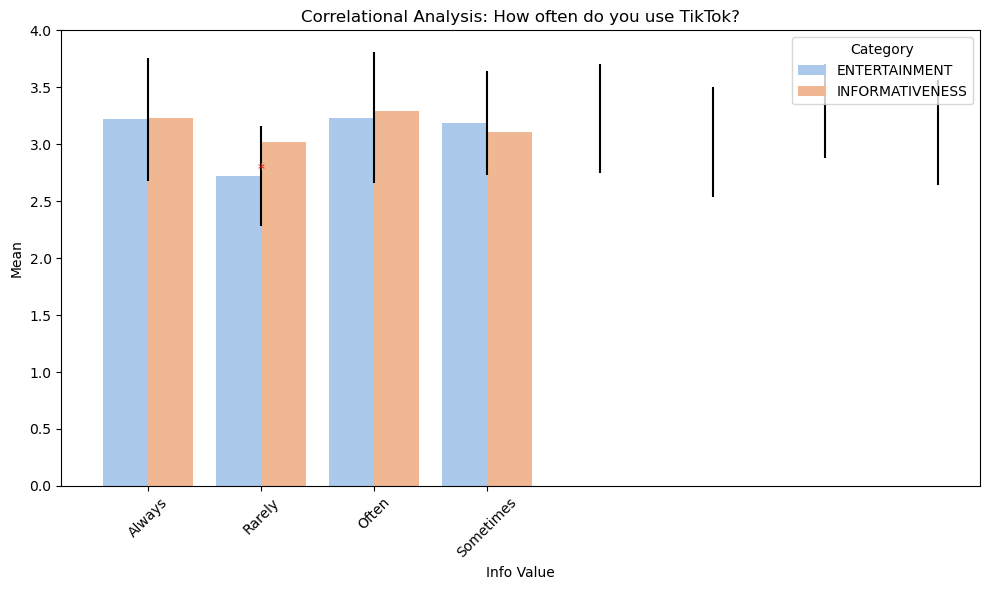


Correlational Analysis for Personal Info: How often do you watch TikTok influencers?
+----+-----------------+--------------+-----+---------+-----------------+-----------+-----------+
|    | Category        | Info Value   |   N |    Mean |   Std Deviation |   T-Value |   P-Value |
+====+=================+==============+=====+=========+=================+===========+===========+
|  0 | ENTERTAINMENT   | Always       |  83 | 3.33133 |         0.54115 |    -1.965 |     0.051 |
+----+-----------------+--------------+-----+---------+-----------------+-----------+-----------+
|  1 | ENTERTAINMENT   | Sometimes    |  59 | 3.07203 |         0.46203 |     1.712 |     0.09  |
+----+-----------------+--------------+-----+---------+-----------------+-----------+-----------+
|  2 | ENTERTAINMENT   | Often        |  51 | 3.19118 |         0.54449 |     0.026 |     0.98  |
+----+-----------------+--------------+-----+---------+-----------------+-----------+-----------+
|  3 | ENTERTAINMENT   | Rarely 

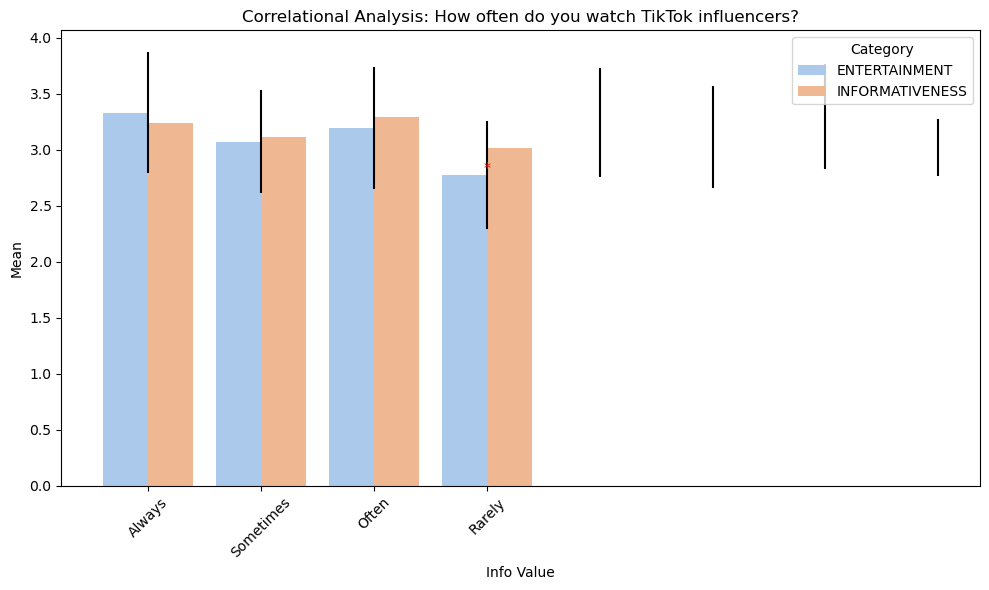


Correlational Analysis for Personal Info: How often do they see endorsement videos of TikTok influencers?
+----+-----------------+--------------+-----+---------+-----------------+-----------+-----------+
|    | Category        | Info Value   |   N |    Mean |   Std Deviation |   T-Value |   P-Value |
+====+=================+==============+=====+=========+=================+===========+===========+
|  0 | ENTERTAINMENT   | Sometimes    |  67 | 3.04104 |         0.5376  |     2.015 |     0.046 |
+----+-----------------+--------------+-----+---------+-----------------+-----------+-----------+
|  1 | ENTERTAINMENT   | Often        |  60 | 3.25    |         0.37394 |    -0.927 |     0.355 |
+----+-----------------+--------------+-----+---------+-----------------+-----------+-----------+
|  2 | ENTERTAINMENT   | Always       |  66 | 3.38636 |         0.51921 |    -2.606 |     0.01  |
+----+-----------------+--------------+-----+---------+-----------------+-----------+-----------+
|  3 | ENTE

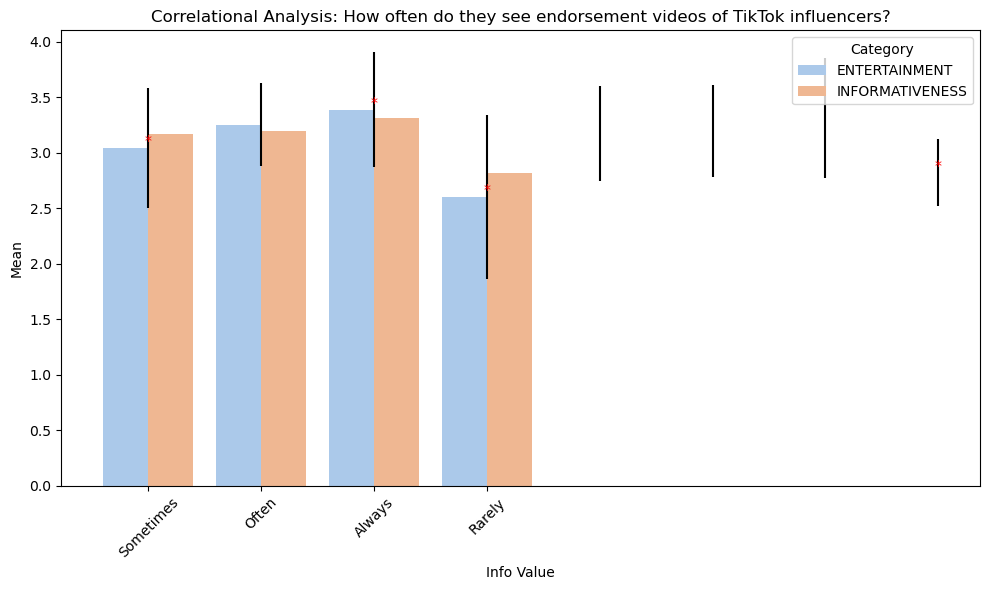

In [24]:
 ### import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from prettytable import PrettyTable
from tabulate import tabulate
from scipy.stats import ttest_ind
import holoviews as hv
import hvplot.pandas

def load_survey_data(filename):
    try:
        if not filename.endswith('.xlsx'):
            raise ValueError("Unsupported file format. Please use an Excel file.")
        return pd.read_excel(filename, header=0)
    except FileNotFoundError:
        print(f"File not found: {filename}")
        return None
    except ValueError as e:
        print(f"Error: {e}")
        return None
    except Exception as e:
        print(f"Unexpected error: {e}")
        return None

def preprocess_data(data, num_personal_info_cols, choice, categorical_mappings):
    if num_personal_info_cols >= data.shape[1]:
        raise ValueError("Number of personal info columns exceeds total columns.")
        
    if choice == 1:
        data = data.dropna()
    elif choice == 2:
        for column in data.columns[num_personal_info_cols:]:
            if data[column].dtype == 'object':
                data[column].fillna(data[column].mode()[0], inplace=True)
            else:
                data[column].fillna(data[column].mean(), inplace=True)
    elif choice == 3:
        fill_value = input("Enter the value to fill missing data with: ")
        data = data.fillna(fill_value)

    # Convert non-numeric responses if present
    if categorical_mappings:
        for column in data.columns:
            if data[column].dtype == 'object':
                data[column] = data[column].map(categorical_mappings).fillna(data[column])

    return data

def analyze_personal_info(data, num_personal_info_cols):
    profile_analysis = {}
    for column in data.columns[:num_personal_info_cols]:
        counts = data[column].value_counts()
        total = len(data[column])
        percentages = (counts / total * 100).round(0).astype(int)
        profile_analysis[column] = pd.DataFrame({
            'Measure': counts.index,
            'Frequency': counts.values,
            'Percentage': percentages.astype(str) + '%'
        })
    return profile_analysis


def display_profile_table(profile_analysis):
    print("\nProfile of the Respondents:")
    for column, df in profile_analysis.items():
        table = PrettyTable()
        table.field_names = df.columns
        for _, row in df.iterrows():
            table.add_row(row)
        print(f"\n{column} Profile:")
        print(table)
        
def convert_categorical_to_numeric(data, categories):
    converted_data = data.copy()
    for category, mappings in categories.items():
        if category in converted_data.columns:
            converted_data[category] = converted_data[category].map(mappings)
    return converted_data
        
def interpret_verbal(mean, reverse_mapping):
    mean_rounded = round(mean)
    return reverse_mapping.get(mean_rounded, "No interpretation available")


def analyze_category(data, categories, num_personal_info_cols, reverse_categorical_mappings):
    category_analysis = {}
    overall_analysis = []
    overall_n = []
    for category, questions in categories.items():
        valid_questions = [q for q in questions if q in data.columns[num_personal_info_cols:]]
        if not valid_questions:
            print(f"Warning: No valid questions found for category '{category}'. Skipping this category.")
            continue

        category_data = data[valid_questions]
        n = len(category_data)
        mean = category_data.mean(numeric_only=True)
        std_dev = category_data.std(numeric_only=True)

        # Creating a list for the category analysis
        analysis_data = []
        
        #For each question and overall category
        for question in valid_questions:
            interpretation = interpret_verbal(mean[question], reverse_categorical_mappings)
            analysis_data.append([question, n, f"{mean[question]:.2f}", f"{std_dev[question]:.2f}", interpretation])

        # Calculate category averages
        total_mean = mean.mean()
        total_std_dev = std_dev.mean()
        total_interpretation = interpret_verbal(total_mean, reverse_categorical_mappings)
        analysis_data.append([f"{category} OVERALL", n, f"{total_mean:.2f}", f"{total_std_dev:.2f}", total_interpretation])
        category_analysis[category] = analysis_data

        # Collect data for overall analysis
        overall_n.append(n)
        if analysis_data:
            overall_analysis.append([category, n, f"{total_mean:.2f}", f"{total_std_dev:.2f}", total_interpretation])

    # Add overall row in overall analysis
    if overall_analysis:
        overall_avg_n = np.mean(overall_n)
        overall_means = np.mean([float(row[2]) for row in overall_analysis])
        overall_stdevs = np.mean([float(row[3]) for row in overall_analysis])
        overall_interpretation = interpret_verbal(overall_means, reverse_categorical_mappings)
        overall_analysis.append(["OVERALL", overall_avg_n, f"{overall_means:.2f}", f"{overall_stdevs:.2f}", overall_interpretation])

    return category_analysis, overall_analysis

# Display category analysis using tabulate
def display_category_analysis(category_analysis):
    for category, data in category_analysis.items():
        print(f"\n[CATEGORY: {category}]")
        print(tabulate(data, headers=["Item", "N", "Mean", "Standard Deviation", "Verbal Interpretation"], tablefmt="grid"))

def display_overall_analysis(overall_analysis):
    print("\n[OVERALL CATEGORY ANALYSIS]")
    headers = ["Category", "N", "Mean", "Standard Deviation", "Verbal Interpretation"]
    print(tabulate(overall_analysis, headers=headers, tablefmt="grid"))
    
def analyze_data(data):
    analysis = {
        'mean': data.mean(numeric_only=True),
        'median': data.median(numeric_only=True),
        'std_dev': data.std(numeric_only=True),
        'min': data.min(numeric_only=True),
        'max': data.max(numeric_only=True)
    }
    return analysis

def interpret_results(analysis):
    interpretation = []
    for key, value in analysis.items():
        formatted_value = f"{value:.2f}" if isinstance(value, (int, float)) else value
        interpretation.append(f"{key.title()}: {formatted_value}")
    return '\n'.join(interpretation)

def prompt_for_correlational_analysis():
    response = input("Do you want to analyze the correlation between categories and personal information? (yes/no): ").lower()
    return response == 'yes'

def select_personal_info_for_analysis(data, num_personal_info_cols):
    print("\nList of Personal Information Options:")
    for i, column in enumerate(data.columns[:num_personal_info_cols], start=1):
        print(f"{i}. {column}")
    selected_indices = input("Enter the indices of personal information for analysis (separated by commas): ")
    selected_columns = [data.columns[int(index.strip()) - 1] for index in selected_indices.split(',') if index.strip().isdigit()]
    return selected_columns

def perform_correlational_analysis(data, categories, personal_info_columns):
    correlational_results = {}
    for personal_info in personal_info_columns:
        results = []
        for category, questions in categories.items():
            category_mean = data[questions].mean(axis=1)  # Calculate the mean of each category for each respondent
            group_data = data[[personal_info]].dropna()
            unique_info_values = group_data[personal_info].unique()
            for info_value in unique_info_values:
                group_mean = category_mean[data[personal_info] == info_value]
                t_stat, p_val = ttest_ind(category_mean, group_mean, equal_var=False)
                results.append([category, info_value, len(group_mean), group_mean.mean(), group_mean.std(), t_stat, p_val])
        correlational_results[personal_info] = pd.DataFrame(results, columns=["Category", "Info Value", "N", "Mean", "Std Deviation", "T-Value", "P-Value"]).round({'Mean': 5, 'Std Deviation': 5, 'T-Value': 3, 'P-Value': 3})
    return correlational_results


def display_correlational_results_with_charts(correlational_results):
    for personal_info, result_df in correlational_results.items():
        print(f"\nCorrelational Analysis for Personal Info: {personal_info}")
        print(tabulate(result_df, headers='keys', tablefmt='grid'))
        for _, row in result_df.iterrows():
            category = row['Category']
            info_value = row['Info Value']
            if row['P-Value'] < 0.05:
                print(f"The analysis shows that {category} has a significant difference with {personal_info} ({info_value}).")
            else:
                print(f"No significant difference found in {category} with {personal_info} ({info_value}).")

        # Plotting bar chart without confidence interval (ci)
        plt.figure(figsize=(10, 6))
        sns.barplot(x='Info Value', y='Mean', data=result_df, hue='Category', errorbar=None, palette='pastel')

        # Adding error bars
        plt.errorbar(x=np.arange(len(result_df)), y=result_df['Mean'], yerr=result_df['Std Deviation'], fmt='none', c='black')

        # Adding annotations for significant differences
        for index, row in result_df.iterrows():
            if row['P-Value'] < 0.05:
                plt.text(index, row['Mean'], '*', ha='center', va='bottom', color='red')

        # Setting title and labels
        plt.title(f'Correlational Analysis: {personal_info}')
        plt.xlabel('Info Value')
        plt.ylabel('Mean')
        plt.legend(title='Category')
        plt.xticks(rotation=45)

        # Show the plot
        plt.tight_layout()
        plt.show()

        
def main():
    filename = input("Enter the filename of the survey data: ")
    data = load_survey_data(filename)

    if data is not None:
        num_personal_info_cols = int(input("Enter the number of columns with personal information: "))
        choice = int(input("Choose how to handle missing data (1: Drop, 2: Fill with mean/mode, 3: Fill with a value): "))
        cleaned_data = preprocess_data(data, num_personal_info_cols, choice, {})

        # Display profile of respondents
        profile_analysis = analyze_personal_info(cleaned_data, num_personal_info_cols)
        display_profile_table(profile_analysis)

        # Map non-numeric responses to numeric values
        response = input("Does the survey contain non-numeric responses such as satisfaction levels (e.g., 'Very Satisfied', 'Satisfied', 'Neutral', 'Dissatisfied')? (yes/no): ").lower()
        categorical_mappings = {}
        if response == 'yes':
            print("\nExample Table for Non-numeric Response Conversion:")
            print(tabulate([['Very Satisfied', 4], ['Satisfied', 3], ['Neutral', 2], ['Dissatisfied', 1]], headers=['Non-numeric', 'Numeric Equivalent'], tablefmt='grid'))
            print("\nThis is just an example. You should create a mapping based on your own survey responses.")
            print("Provide a numeric equivalent for each non-numeric response:")
            while True:
                cat_response = input("Enter a non-numeric response (or 'done' to finish): ")
                if cat_response.lower() == 'done':
                    break
                numeric_value = int(input(f"Numeric value for '{cat_response}': "))
                categorical_mappings[cat_response] = numeric_value

        cleaned_data = preprocess_data(data, num_personal_info_cols, choice, categorical_mappings)

        # Display survey questions
        print("\nList of Survey Questions:")
        for i, question in enumerate(cleaned_data.columns[num_personal_info_cols:], start=1):
            print(f"{i}. {question}")

        # Category analysis
        print("\nIn this survey, do you have groups of questions that together measure a specific theme or aspect?")
        print("For example, a group named 'User Experience' might include questions specifically about the user's interaction with a product.")
        print("These groups help in analyzing specific themes or aspects in your survey data.")
        category_input = input("Do you have such groups or themes in your survey to analyze? (yes/no): ").lower()
        categories = {}
        if category_input == 'yes':
            print("\nEnter the name of the group or theme, followed by the question numbers that fall under it.")
            while True:
                category_name = input("Enter the group/theme name (or 'done' to finish): ")
                if category_name.lower() == 'done':
                    break
                question_nums = input(f"Enter question numbers for the '{category_name}' group/theme (separated by commas): ")
                question_indices = [int(num.strip()) - 1 for num in question_nums.split(',') if num.strip().isdigit()]
                questions = [cleaned_data.columns[num_personal_info_cols + i] for i in question_indices]
                categories[category_name] = questions

        # Define reverse_categorical_mappings here if necessary
        reverse_categorical_mappings = {
            1: 'Low',
            2: 'Medium',
            3: 'High',
            4: 'Very High'
        }

        if categories:
            category_analysis, overall_analysis = analyze_category(cleaned_data, categories, num_personal_info_cols, reverse_categorical_mappings)
            display_category_analysis(category_analysis)
            display_overall_analysis(overall_analysis)

        # Correlational Analysis
        if prompt_for_correlational_analysis():
            personal_info_columns = select_personal_info_for_analysis(cleaned_data, num_personal_info_cols)
            correlational_results = perform_correlational_analysis(cleaned_data, categories, personal_info_columns)
            display_correlational_results_with_charts(correlational_results)

    else:
        print("No data available for analysis.")

main()